In [21]:
#import matplotlib
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import metpy.calc as mpc
import xarray as xr
import pandas as pd
import datetime as dt
#from scam_func import *


In [103]:
#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######
#scam_file_in = './FSCAM.T42_T42.SAS.001.cam.h0.2013-06-10-43200.nc'   # input template (default: 20min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.002.cam.h0.2013-06-10-43200.nc'   # input template (5min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.003.cam.h0.2013-06-10-43200.nc'   # input template (1min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.007.cam.h0.2013-06-10-43200.nc'   # input template, fixed q for SCAM (double,kg/kg), shflx/lhflx prescribed (default: 20min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.008.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.
#scam_file_in = './FSCAM.T42_T42.SAS.011b.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.


scam_file_num = '012a'  # For detailed single case analysis
#scam_file_nums = ['011a','011b','011c','011d']  # For comparisons
scam_file_nums = ['012','012a']  # For comparisons

scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-43200.nc"

zoffset = 6.


#### PLOTTING ####

pvars_ts1d = np.array(['TS','PBLH','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
pvars_ts2d = ['T','Q','RELHUM']
#pvars_ts2d = ['T','Q','RELHUM','CLOUD','ZMDQ','ZMDT','STEND_CLUBB','RVMTEND_CLUBB'] # 2D profile timeseries plots
pvars_snap = ['T','Q','TH','THL']  # Snapshot plotting vars
pvars_anim = np.array(('T','RELHUM'))

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (local time)


####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
%matplotlib inline


#### CONSTANTS #####

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004.6 # Specific heat for dry air
Lv = 2.501e6      # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.
p0 = 100000. # pref 

###### DERIVED VARS #######
scam_files_in = [scam_file_pre+x+scam_file_suf for x in scam_file_nums]
print(scam_file_nums)
scam_file_in = scam_file_pre+scam_file_num+scam_file_suf 
scam_fig_stub='png/'+'_'.join(scam_file_nums)
print(scam_fig_stub)
print('Reading in data from file = ',scam_files_in)

##### Point Files #######
print(scam_files_in)
scam_in = xr.open_mfdataset(scam_files_in,concat_dim='case')



#scam_in = xr.open_dataset(scam_file_in,engine='netcdf4')
#print(scam_in)
#print(xr.concat([scam_in], dim='case'))

xr.set_options(keep_attrs=True)



## Dimensions

time = scam_in.time
hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
vplevs = scam_in['lev'].transpose()
ntsnaps = tsnaps.size
ncases = len(scam_file_nums)

## Vertical range to plot

pptop = 200.
ipplevs = np.where(vplevs>=pptop) ; ip0 = np.min(ipplevs) ; ip1 = np.max(ipplevs)
vplevs_v = vplevs[ip0:ip1]

['012', '012a']
png/012_012a
Reading in data from file =  ['FSCAM.T42_T42.SAS.012.cam.h0.2013-06-10-43200.nc', 'FSCAM.T42_T42.SAS.012a.cam.h0.2013-06-10-43200.nc']
['FSCAM.T42_T42.SAS.012.cam.h0.2013-06-10-43200.nc', 'FSCAM.T42_T42.SAS.012a.cam.h0.2013-06-10-43200.nc']


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Temperature  -- cmin/cmax -->  190.0 330.0
Case =  012 Range= 177.70714 321.44867
1 2
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Specific humidity  -- cmin/cmax -->  1.0 20.0
Case =  012 Range= 1e-12 0.016382515
1 2
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>   Relative humidity  -- cmin/cmax -->  10.0 120.0
Case =  012 Range= 4.9903655e-09 101.781136
1 2


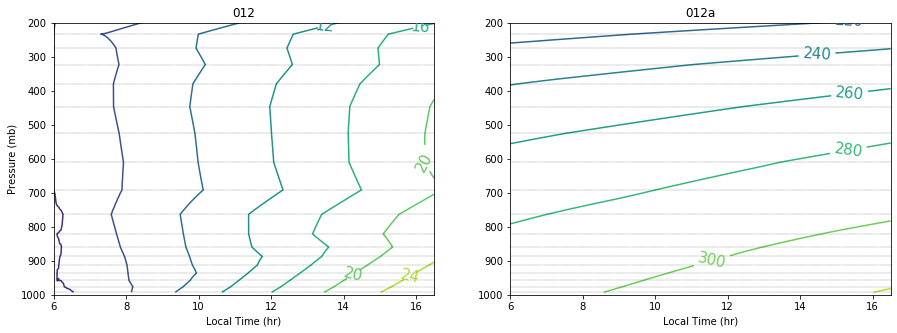

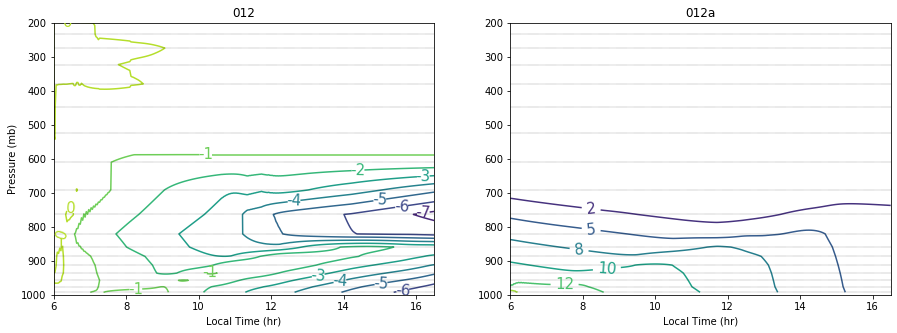

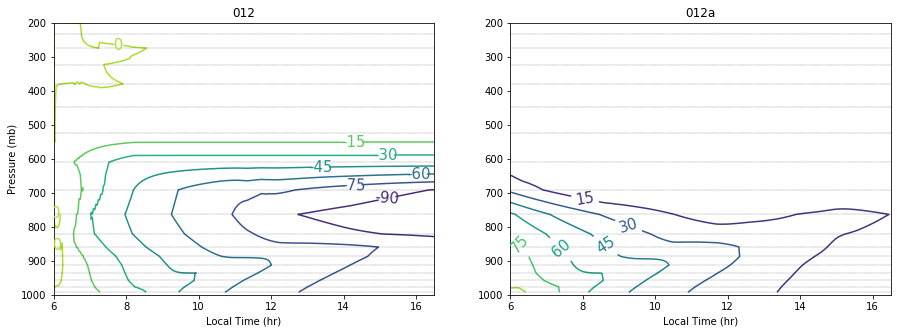

In [124]:
###### Plotting ##########

#plot1d_ts_scam()   # 1D time series plots
plot2d_ts_scam()   # 2D time series plots
#plot1d_snap_scam()   # 1D snapshot plots
#plot1d_anim_scam() # 2D animation  plots


In [ ]:
#fig = mp.figure()
#ax = mp.axes(xlim=(0, 4), ylim=(-2, 2))
#line, = ax.plot([], [], lw=3)

#def init():
#    line.set_data([], [])
#    return line,
#def animate(i):
#    x = np.linspace(0, 4, 1000)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    line.set_data(x, y)
#    return line,

#anim = FuncAnimation(fig, animate, init_func=init,
##                               frames=100, interval=40, blit=True)
#HTML(anim.to_html5_video())


#mp.show()

#fig.show()
#anim.save('sine_wave.gif', writer='imagemagick')


In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

In [17]:

################################
#   1D Timeseries plotting     #
################################


def plot1d_ts_scam():
    
    plot1d_dic = {}

    plot1d_dic['LHFLX']  = [1.,0.,300]
    plot1d_dic['SHFLX']  = [1.,0., 300]
    plot1d_dic['TS']     = [1., 290., 300.]
    plot1d_dic['PBLH']   = [1., 0., 1000.]
    plot1d_dic['PRECL']  = [86400.*1000., 0., 10.]
    plot1d_dic['PRECC']  = [86400.*1000., 0., 10.]
    plot1d_dic['FLNS']   = [1., 200., 800.]
    plot1d_dic['CAPE']   = [1., 0., 800.]

    plot1d_df = pd.DataFrame(plot1d_dic,index=['vscale','cmin','cmax'])
    plot1d_df
    
## 1D PLOTS ##
#mp.rcParams['figure.dpi'] = 50

    for var in pvars_ts1d:
 
        vscale = plot1d_dic[var][0] ; cmin = plot1d_dic[var][1] ; cmax = plot1d_dic[var][2]
  
        with xr.set_options(keep_attrs=True): 
            pvar = vscale*scam_in[var].isel(lat=0,lon=0)

        
        # Fig. setup
        print('---- PLOTTING 1D TIME PLOTS ------>>>  ',pvar.attrs['long_name'],' --amin/cmax --> ',  np.min(pvar.values),np.max(pvar.values))
        
        # Loop cases and plot
        for icase in range(ncases):
            mp.plot(hour_frac,pvar[icase,:])
  
    
    # Axes stuff
        mp.xlabel("Local Time (hr)")
        mp.ylabel(pvar.attrs['units'])
        mp.title(pvar.attrs['long_name'])
        
#        mp.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        mp.legend(labels=scam_file_nums, ncol=1, loc="center right", fontsize="medium",
                columnspacing=1.0, labelspacing=0.8, bbox_to_anchor= (0.97, 0.83),
                handletextpad=0.5, handlelength=1.5, borderaxespad=-5,
                framealpha=1.0,frameon=True)
#        mp.show()
        mp.savefig(scam_fig_stub+'_plot1d_ts_scam_'+var+'.png')     
        mp.close()
        
        
        
        
   

In [123]:
############################################
# 2D Time/Height Timeseries Plotting info. #
############################################ 


def plot2d_ts_scam():

    plot2d_dic = {}

    plot2d_dic['T']      = [1.,190.,330.]
    plot2d_dic['RELHUM'] = [1.,10., 120.]
    plot2d_dic['CLOUD']  = [100., 0., 100.]
    plot2d_dic['Q']      = [1000., 1., 20.]
    plot2d_dic['WPRTP_CLUBB'] = [1., 0., 200.]
    plot2d_dic['WPTHLP_CLUBB'] = [1., 0., 200.]
    plot2d_dic['WP3_CLUBB']      = [1., -1., 1.]
    plot2d_dic['STEND_CLUBB']    = [1., -.5, 0.55]
    plot2d_dic['RVMTEND_CLUBB']  = [1000.*86400, -30., 30.]
    plot2d_dic['DCQ']  = [1000., -5., 5.]
    plot2d_dic['THL']  = [1., 210, 310.]
    plot2d_dic['ZMDT']  = [86400., -5., 5.]
    plot2d_dic['ZMDQ']  = [86400.*1000., -5., 5.]

    plot2d_df = pd.DataFrame(plot2d_dic,index=['vscale','cmin','cmax'])
    plot2d_df

    nclevs = 20 # Number of contour levels


## TIME/HEIGHT PLOTTING ##
#    mp.rcParams['figure.dpi'] = 70

    for var in pvars_ts2d:

        vscale = plot2d_dic[var][0] ; cmin = plot2d_dic[var][1] ; cmax = plot2d_dic[var][2]
        plevels = np.arange(cmin,cmax,(cmax-cmin)/nclevs)
       
        # First case plot (could be only plot)
        pvar = scam_in[var].isel(lat=0,lon=0).transpose()
        print('---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  ',pvar.attrs['long_name'],' -- cmin/cmax --> ',cmin,cmax)               
        print('Case = ',scam_file_nums[0],'Range=',np.min(pvar.values),np.max(pvar.values))

        
# First plot

        fig1 = mp.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(111)
        pvarp = vscale*pvar.isel(case=0)
        
        pvarp = pvarp-pvarp[:,0] # Remove initial column values
        
#        ax1.ylim(1000., 200.)
        plt0 = ax1.contour(hour_frac,scam_in['lev'],pvarp) 
      
                
        ax1.clabel(plt0, fontsize=15, inline=1,fmt='%1.0f')
        mp.hlines(scam_in['lev'], min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)
        ax1.set_title(scam_file_nums[0])
        ax1.set_ylabel('Pressure (mb)') 
        ax1.set_xlabel("Local Time (hr)")  
        ax1.set_ylim(200, 1000.)
        ax1.invert_yaxis()  
       
        
 # Loop for subsequent plots       
        nn = len(fig1.axes)
        for icase in range(1,ncases):
            pvarp = vscale*pvar.isel(case=icase)
        
#            pvarp = pvarp-pvarp[:,0] # Remove initial column values
            
            nn = len(fig1.axes)
            print(nn,ncases)
            for i in range(nn):
                fig1.axes[i].change_geometry(1, nn+1, i+1)
            ax1 = fig1.add_subplot(1, nn+1, nn+1)
  
            plt0 = ax1.contour(hour_frac,scam_in['lev'],pvarp)
            ax1.clabel(plt0, fontsize=15, inline=1,fmt='%1.0f')
            mp.hlines(scam_in['lev'], min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)
            ax1.set_title(scam_file_nums[icase])
            ax1.set_xlabel("Local Time (hr)")
            ax1.set_ylim(200, 1000.)
            ax1.invert_yaxis()

            #        fig,ax = mp.subplots()        

#        p_tp = ax.contour(hour_frac,scam_in[pvar.dims[0]],vscale*pvar,levels=plevels)
#        ax.invert_yaxis()
#        mp.clabel(p_tp, fontsize=9, inline=1,fmt='%1.0f')
#        mp.hlines(scam_in[pvar.dims[0]], min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.04)
#        ax.set_xlabel("Local Time (hr)")
#        ax.set_ylabel("Pressure (mb)")
#        ax.set_title(var+" - "+pvar.attrs['long_name']+" ("+pvar.attrs['units']+")")

        
        
#        mp.show()
        mp.savefig(scam_fig_stub+'_plot2d_ts_scam_'+var+'.png')
        
        del pvar       
        
        
        
     

In [34]:
   
        
        
        
##########################################
# 2D Snapshot/Height Timeseries Plotting info.
##########################################


def plot1d_snap_scam():
              
    for var in pvars_snap:

        pvar = None

        if var =='TH' : pvar = scam_in['T'].isel(lat=0,lon=0)*(0.01*p0/vplevs)**r_cp ; pvar.attrs['long_name'] = "Potential Temperature" ; pvar.attrs['units'] = "K" ; theta = pvar
        if var =='THL': pvar = theta-(theta/scam_in['T'].isel(lat=0,lon=0))*(Lv/cp_air)*scam_in['Q'].isel(lat=0,lon=0) ; pvar.attrs['long_name'] = "Liq. Water Potential Temperature"

        if pvar is None :  # Set pvar if not already.
            pvar = scam_in[var].isel(lat=0,lon=0)

        print('------ SNAPSHOTS ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

        # Plot several different functions...

        labelspacing = []
        labels = []

        ## Loop Snapshot Times ##

        for ii in range(0, ntsnaps): 
            itt = np.min(np.where(hour_frac==tsnaps[ii]))
            pvar_v = pvar[itt,ip0:ip1]
            mp.plot(pvar_v,vplevs_v)

    #        if var not in ['T','TH','THL']: mp.vlines(0, 0, scam_in[pvar.dims[1]].max(), linestyle="dashed",lw=1)
            mp.hlines(vplevs_v, min(pvar_v), max(pvar_v), linestyle="dotted",lw=0.04)

    ######### END of snapshot loop #########

    # Legend
        mp.title(pvar.attrs['long_name']+' ('+pvar.attrs['units']+')')
        mp.legend(labels=tsnaps, ncol=2, loc="center right", 
                columnspacing=1.0, labelspacing=1, 
                handletextpad=0.5, handlelength=0.5, frameon=False)
        print(pvar.attrs['units'])
        mp.gca().invert_yaxis()
        mp.show()
        del pvar       

        
        
        
        
        
        
        

In [27]:
        
#########################################
# 1D/TIME ANIMATIONS
#########################################

        
        
        
        
def plot1d_anim_scam():
    
    nanim_vars = pvars_anim.size
    
#    fig, ax = mp.subplots(nrows=1, ncols=nanim_vars,figsize=(15, 5)))
   
    
# 
#    def init():
#        line.set_data([], [])
#        return line,
#    def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line,

#    line, = ax.plot(x, np.sin(x))
          
    for var in pvars_anim:

        pvar = None

        if var =='TH': pvar = scam_in['T'].isel(lat=0,lon=0)*(0.01*p0/vplevs)**r_cp ; pvar.attrs['long_name'] = "Potential Temperature" ; pvar.attrs['units'] = "K" ; theta = pvar
        if var =='THL': pvar = theta-(theta/scam_in['T'].isel(lat=0,lon=0))*(Lv/cp_air)*scam_in['Q'].isel(lat=0,lon=0) ; pvar.attrs['long_name'] = "Liq. Water Potential Temperature"

        if pvar is None :  # Set pvar if not already.
            pvar = scam_in[var].isel(lat=0,lon=0)

        print('------ Animations ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

    # Dynamically allocate subplots and animate Animate

#    ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
    
  
    fig = mp.figure()
    
    
# Plotting frame.    
    ax = fig.add_subplot(111)
    ax.set_ylabel('mb') 
    for ip in range(1,5):
        n = len(fig.axes)
        print(n)
        for i in range(n):
            fig.axes[i].change_geometry(1, n+1, i+1)
        ax = fig.add_subplot(1, n+1, n+1)   
        
    def animate(ii):
        print(n)
        for i in range(n):
            ax[n].plot[i](pvar[ii,:],vplevs) 
    
#        del fig.axes
#        mp.show()
#        return ax
        
        
#    def animate(ii):
#        print(len(fig.axes))
#        ax = fig.add_subplot(111)
#        
#        ax.set_ylabel('mb') 
#        ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        for ip in range(1,2):
#            n = len(fig.axes)
#            print("hi2",n)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        del fig.axes
#        mp.show()
#        return ax
    print(fig.axes)
    animate(0)
    mp.show()
    
#    print(fig)
#    animate(1)
#    print(fig)
#    animate(200)
        
#
#       def init():
#        line.set_data([], [])
#        return line,     
    
#       def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line, 
#        for ip in range(pvars_anim.size-1):
#            n = len(fig.axes)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
        
        
    anim = FuncAnimation(fig, animate, frames=np.arange(1,10))
#    print(anim)
    #    mp.show()
    mp.show()
    HTML(anim.to_html5_video())

    del pvar
    
   

IndentationError: expected an indented block (<ipython-input-27-cedfdf6bdb35>, line 31)